# Custom modules

In [1]:
import sys
sys.path.insert(1, '../../machine-learning')
sys.path.insert(1, '../../homewise/ds-core')

from size import size
from to_csv_to_zip import to_csv_to_zip
from fit_cache import fit_cache

# Standard modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import pickle
from time import time
from datetime import datetime
import warnings

# Load and prepare data

In [3]:
model_dir = '/data/drivendata/models/2022/'
prediction_dir = '/data/drivendata/predictions/2022/'

df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)

# Feature layout
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing',
          'Student_Type', 'Use']
NUMERIC_FEATURES = ['FTE', 'Total']
TEXT_FEATURES = ['Object_Description', 'Sub_Object_Description', 'Function_Description', 'Fund_Description',
                 'SubFund_Description', 'Program_Description', 'Location_Description', 'Facility_or_Department',
                 'Job_Title_Description', 'Position_Extra', 'Text_1', 'Text_2', 'Text_3', 'Text_4']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES

# strip spaces and lower case of text features columns
# df[TEXT_FEATURES] = df[TEXT_FEATURES].apply(lambda x: x.str.strip().str.lower())
# holdout[TEXT_FEATURES] = holdout[TEXT_FEATURES].apply(lambda x: x.str.strip().str.lower())

# shuffling training data
df = df.sample(frac=1, random_state=1)

# get dummy variables from labels
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
y = pd.get_dummies(df[LABELS], prefix_sep='__')

# Model metric: multi-multi log loss

In [4]:
from dummies import get_dummies_indices
from sklearn.metrics import make_scorer
from metrics.log_loss import multi_multi_log_loss
cci = get_dummies_indices(df[LABELS])
multi_multi_log_loss_scorer = make_scorer(multi_multi_log_loss, greater_is_better=False, needs_proba=True,
                                          class_column_indices=cci)
multi_multi_log_loss_scorer

make_scorer(multi_multi_log_loss, greater_is_better=False, needs_proba=True, class_column_indices=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75], [76, 77, 78], [79, 80, 81], [82, 83, 84, 85, 86], [87, 88, 89, 90, 91, 92, 93, 94, 95], [96, 97, 98, 99, 100, 101, 102, 103]])

# Candidate classifiers

[DummyClassifier(*, strategy='prior', random_state=None, constant=None)](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn-dummy-dummyclassifier)

    strategy={“most_frequent”, “prior”, “stratified”, “uniform”, “constant”}
    
[LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn-linear-model-logisticregression)

    penalty={‘l1’, ‘l2’, ‘elasticnet’, ‘none’}
    tol=1e-4
    C=1.0
    fit_intercept=True
    class_weight=dict or ‘balanced’, default=None
    random_state=None #Used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data.
    solver={‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}
        For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
        For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
        ‘liblinear’ is limited to one-versus-rest schemes.
        The choice of the algorithm depends on the penalty chosen: Supported penalties by solver:
            ‘newton-cg’ - [‘l2’, ‘none’]
            ‘lbfgs’ - [‘l2’, ‘none’]
            ‘liblinear’ - [‘l1’, ‘l2’]
            ‘sag’ - [‘l2’, ‘none’]
            ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]
    max_iter=100
    multi_class{‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’
        If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss
        minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary.
        ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or
        if solver=’liblinear’, and otherwise selects ‘multinomial’.
    warm_start=False
        When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the
        previous solution. Useless for liblinear solver.
    n_jobs=None
    l1_ratio=None
        The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1.

[OneVsRestClassifier(estimator, *, n_jobs=None, verbose=0)](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn-multiclass-onevsrestclassifier)

    n_jobs=None
        
[RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier)
  
    n_estimators=100
    criterion={“gini”, “entropy”, “log_loss”}, default=”gini”
    max_depth=None
        The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
        less than min_samples_split samples.
    min_samples_split=2
        The minimum number of samples required to split an internal node:
            If int, then consider min_samples_split as the minimum number.
            If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of
            samples for each split.
    min_samples_leaf=1
        The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it
        leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of
        smoothing the model, especially in regression.
            If int, then consider min_samples_leaf as the minimum number.
            If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of
            samplesfor each node.
    max_features={“sqrt”, “log2”, None}, int or float, default=”sqrt”
        The number of features to consider when looking for the best split:
            If int, then consider max_features features at each split.
            If float, then max_features is a fraction and max(1, int(max_features * n_features_in_)) features are considered at
            each split.
            If “auto”, then max_features=sqrt(n_features).
            If “sqrt”, then max_features=sqrt(n_features).
            If “log2”, then max_features=log2(n_features).
            If None, then max_features=n_features.
    bootstrap=True
        Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
    n_jobs=None
    random_state=None (means 1),int, RandomState instance or None, default=None
        Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the
        sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
    warm_start=False
        When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise,
        just fit a whole new forest.
    class_weight={“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have
        weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
        Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict.
        For example, for four-class multilabel classification weights should be [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1},
        {0: 1, 1: 1}] instead of [{1:1}, {2:5}, {3:1}, {4:1}].
        The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
        in the input data as n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample
        for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is
        specified.
        
[GaussianNB(*, priors=None, var_smoothing=1e-09)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn-naive-bayes-gaussiannb)

[MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn-naive-bayes-multinomialnb)

[ComplementNB(*, alpha=1.0, fit_prior=True, class_prior=None, norm=False)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn-naive-bayes-complementnb)

[SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn-svm-svc)

[KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier)

[XGBClassifier(*, objective='binar':logistic', use_label_encoder=False, **kwargs)](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)



In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Baseline pipeline

In [6]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, MissingIndicator, IterativeImputer, KNNImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MaxAbsScaler, Normalizer, PolynomialFeatures

In [7]:
from preprocessing.disambiguate import disambiguate
from preprocessing.combine_text_columns import combine_text_columns
from nlp import custom_sentence_tokenizer

get_numeric_data = FunctionTransformer(disambiguate, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total', 'sparse':True})

get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': LABELS, 'sep':' '})

In [68]:
baseline_pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', Pipeline([
            ('numeric_selector', get_numeric_data),
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True))
        ], verbose=False #, memory='/data/drivendata/cache'
        )),
        ('text_features' , Pipeline([
            ('text_selector', get_text_data),
            ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False,
                                             token_pattern='(?u)\\b\\w+\\b', dtype='uint8')),
            ('reducer', SelectKBest(score_func=chi2))
        ], verbose=False #, memory='/data/drivendata/cache'
        ))
    ], verbose=False, n_jobs=None
    )),
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', MaxAbsScaler()),
    ('classifier', OneVsRestClassifier(
        LogisticRegression(C=1.0, random_state=1, solver='liblinear', n_jobs=None, verbose=0),
        n_jobs=None, verbose=0))
], verbose=False #, memory='/data/drivendata/cache'
)

# Learning and validation curves

In [9]:
from model_selection.multilabel import multilabel_sample_dataframe, multilabel_train_test_split
from model_selection.learning_curve import plot_learning_curve
from model_selection.validation_curve import plot_validation_curve
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from max_interactions import max_interactions
train_sizes = np.linspace(0.2, 1, 5)

## Estimators

The learning curves help comparing algorithms for bias-variance behavior, choosing model parameters during design, adjusting optimization to improve convergence and determining the amount of data used for training.

In this pipeline, the amount of data is determined not only by the sample size, but also by:
* the feature generation step `HashingVectorizer` with its parameter `ngram_range`.
* the feature selection step `SelectKBest(chi2)` with its parameter `k`.
* the feature generation step `PolynomialFeatures` with its parameters fixed.

Initially, it's picked main classification algorithms that support specific characteristics of the pipeline:
* Sparse data produced by the `HashingVectorizer` 
* Negative numbers present in the numeric features `Total`and `FTE`.

Because of this characteristics, alghorithms such as Naive Bayes can't be used:
* `GaussianNB` requires dense data
* `MultinomialNB` requires positive numbers.

Other alghorithms were much slow hence it's limited to `LogisticRegression`.  This limitation is expected to be removed in a future version.

The train sizes is a sligthly variation of the [default](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve) `np.linspace(0.1, 1.0, 5)` to keep evenly spaced intervals.

In [10]:
classifiers = [OneVsRestClassifier(LogisticRegression(C=1.0, random_state=1, solver='liblinear', max_iter=100, n_jobs=None, verbose=0), n_jobs=None, verbose=0),
               #OneVsRestClassifier(DummyClassifier(strategy='uniform', random_state=1), n_jobs=None, verbose=0)
               # OneVsRestClassifier(SVC(probability=True)),
               # OneVsRestClassifier(XGBClassifier()),
               # OneVsRestClassifier(RandomForestClassifier()),
               # OneVsRestClassifier(KNeighborsClassifier())
              ]
for c in classifiers:
    print(' '.join(repr(c).split()))

OneVsRestClassifier(estimator=LogisticRegression(random_state=1, solver='liblinear'))


## `k` parameter space

Finding the best endpoint criteria for the `k` parameter space.

In [11]:
def k_space(start=1, stop=None, num=5, endpoint=True):
    if start > stop:
        raise ValueError(f'start {start} greater than stop {stop}')
    start = min(start, stop)
    num = min(num, stop)
    return np.logspace(start=np.log10(start), stop=np.log10(stop), num=num, endpoint=endpoint).round().astype('int').tolist()

n-gram vocabulary size

In [12]:
from nlp2 import ngram_vocabulary_size
vocabulary_size = ngram_vocabulary_size(df[TEXT_FEATURES])
k_space(start=np.sqrt(vocabulary_size),
        stop=vocabulary_size)

[61, 172, 480, 1343, 3758]

Max $k$ features to interact up to the `n_features`: $2^{20}$ (1,048,576), considering the preexisting $j=6$ numeric features.

In [13]:
j = 6; n_features = 2**20
k_space(start=np.sqrt(max_interactions(n_features, j)),
        stop=max_interactions(n_features, j))

[38, 94, 234, 581, 1441]

Max $k$ features to interact up to the combination of unique labels and classes, considering the preexisting $j=6$ numeric features.

In [14]:
y_nunique = y.value_counts().shape[0]
k_space(start=np.sqrt(max_interactions(y_nunique * y.shape[1], j)),
        stop=max_interactions(y_nunique * y.shape[1], j))

[33, 78, 186, 444, 1062]

## Parameter grid

* tokenizer: default (None) or custom_sentence_tokenizer
* sep: ' ' for default tokenizer or '. ' for custom_sentence_tokenizer
* token_pattern: Regex '\\\w+' or '\\\w\\\w+' for default tokenizer or None for custom_sentence_tokenizer
* ngram_range: (1,3) for default tokenizer and (1,1) for custom_sentence_tokenizer
* k parameter space for default tokenizer: for each ngram_range and token_pattern
* k parameter space for custom_sentence_tokenizer: for each ngram_range
* for each classifier

In [75]:
def build_parameter_grid(# token_pattern=['(?u)\\b\\w+\\b'],
                         # word_ngrams=1, sentence_ngrams=1,
                         # sentence_tokenizer=custom_sentence_tokenizer, sentence_separator='. ',
                         classifiers=[None], k=[None]):
    param_grid = \
    [
        {#'union__numeric_features__imputer__add_indicator': [False, True],
         #'union__text_features__text_selector__kw_args': [{'sep': ' '}],
         #'union__text_features__vectorizer__tokenizer': [None],
         #'union__text_features__vectorizer__token_pattern': token_pattern,
         #'union__text_features__vectorizer__ngram_range': [(1,n) for n in range(1, word_ngrams+1)],
         'union__text_features__reducer__k': k,
         'classifier__estimator': classifiers
         },
        # {'union__text_features__vectorizer__tokenizer': [sentence_tokenizer],
        #  'union__text_features__text_selector__kw_args': [{'sep': sentence_separator}],
        #  'union__text_features__vectorizer__token_pattern': [None],
        #  'union__text_features__vectorizer__ngram_range': [(1,n) for n in range(1, sentence_ngrams+1)],
        #  'union__text_features__reducer__k': k,
        #  'classifier__estimator': classifiers
        #  }
    ]
    return ParameterGrid(param_grid)

## Plot function

In [65]:
from sklearn.base import clone
def multi_plot_learning_curves(pl, parameter_grid, X, y, cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=None, train_sizes=np.linspace(0.2, 1, 5), verbose=0, figsize=(17,17/5)):
    for parameter in parameter_grid:
        cloned_pl = clone(pl)
        cloned_pl.set_params(**parameter)
        # print(', '.join([k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]))
        # pl.fit(sampling[FEATURES], dummy_labels)
        # print(f'Training Accuracy: {pl.score(sampling[FEATURES], dummy_labels)} Logloss: {multi_multi_log_loss(dummy_labels, pl.predict_proba(sampling[FEATURES]), class_column_indices=cci)}')
        plot_learning_curve(estimator=cloned_pl,
                            title=', '.join([k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            X=X,
                            y=y,
                            cv=cv,
                            n_jobs=n_jobs, 
                            scoring=scoring,
                            train_sizes=train_sizes,
                            verbose=verbose,
                            alpha=0.2,
                            figsize=figsize
                           )
        plt.show()

# 1% data sample

In [88]:
sampling = multilabel_sample_dataframe(df, y, size=0.01, min_count=28, seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
vocabulary_size = ngram_vocabulary_size(sampling[TEXT_FEATURES])
print('Sample size    :', sampling.shape[0])
print('Train sizes    :', (sampling.shape[0] * train_sizes * .8).astype('int'))
print('Test sizes     :', (sampling.shape[0] - (sampling.shape[0] * train_sizes * .8)).astype('int'))
print('Vocabulary size:', vocabulary_size)

Sample size    : 4002
Train sizes    : [ 640 1280 1920 2561 3201]
Test sizes     : [3361 2721 2081 1440  800]
Vocabulary size: 1653


## Learning curves

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(


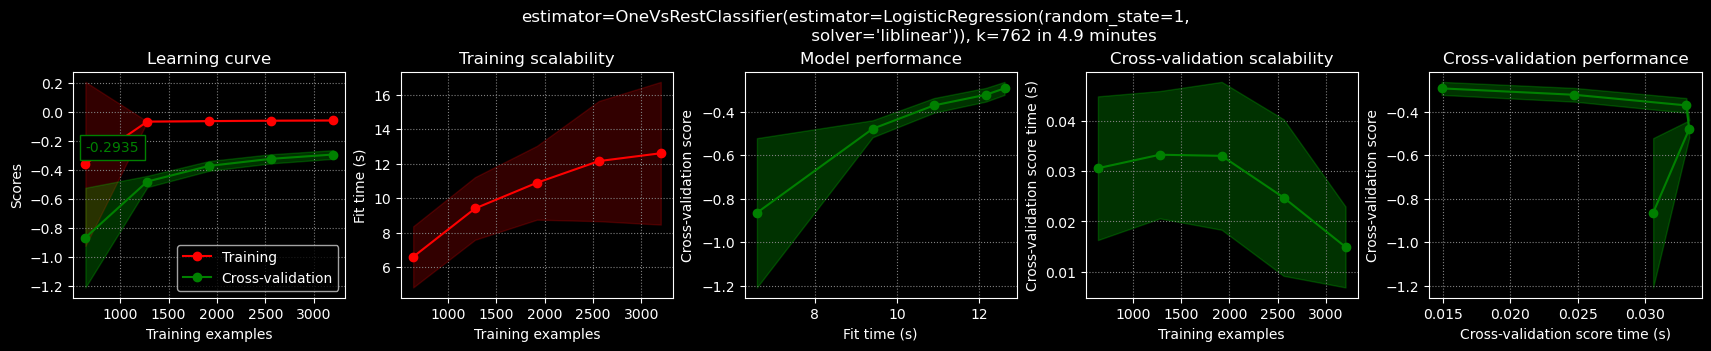

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(


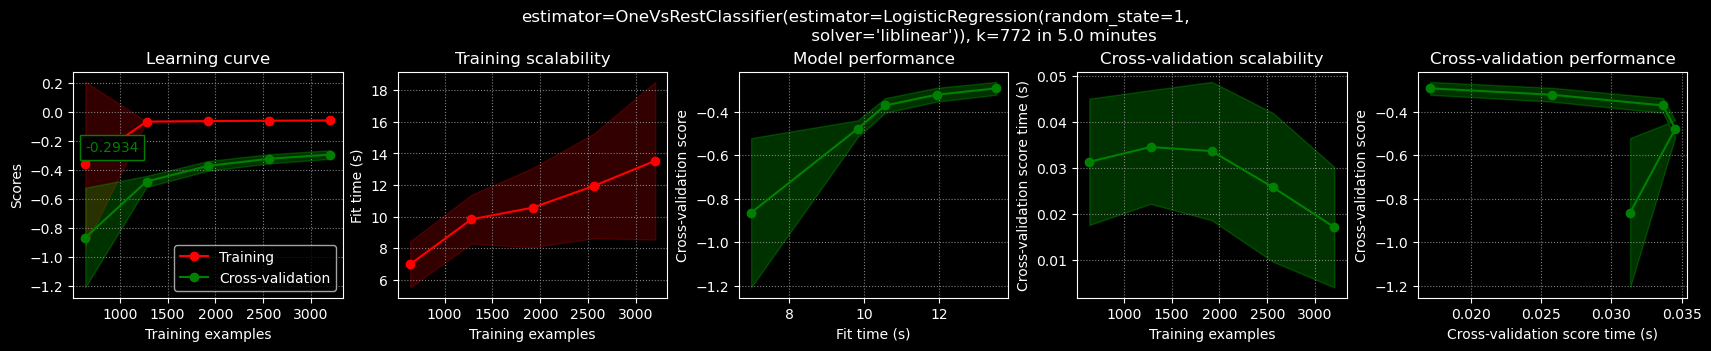

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(


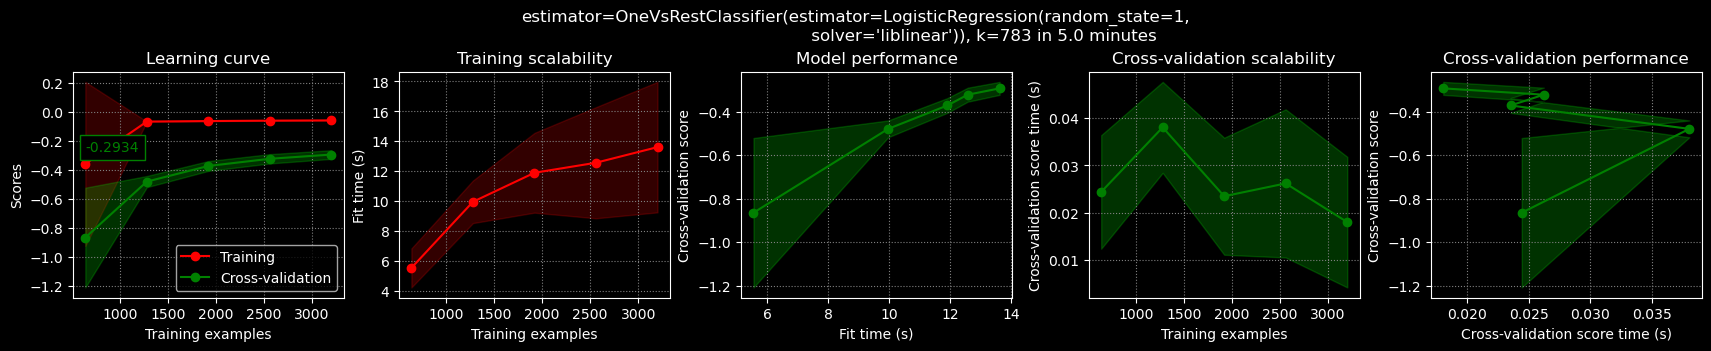

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(


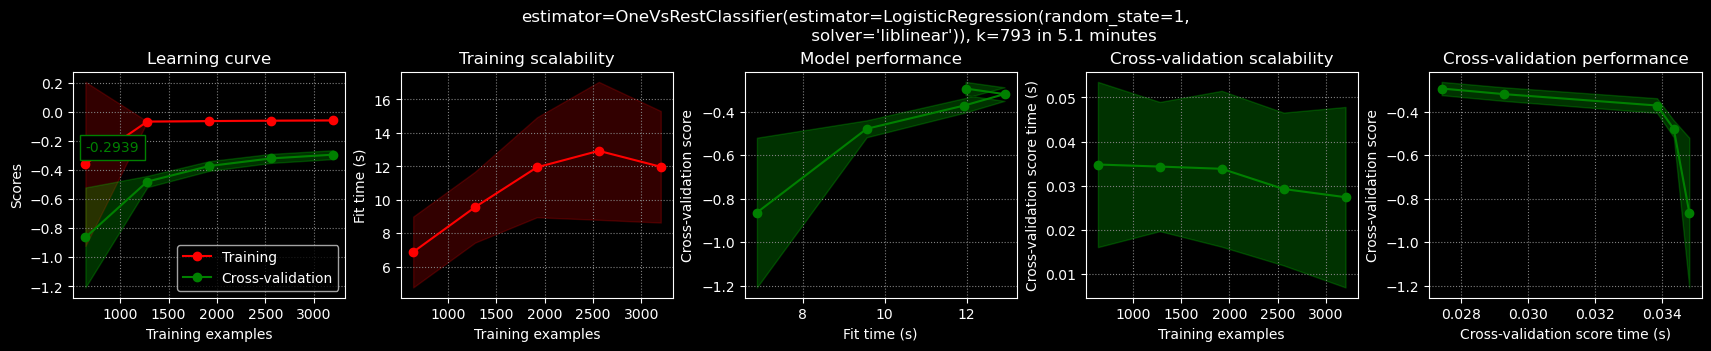

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(


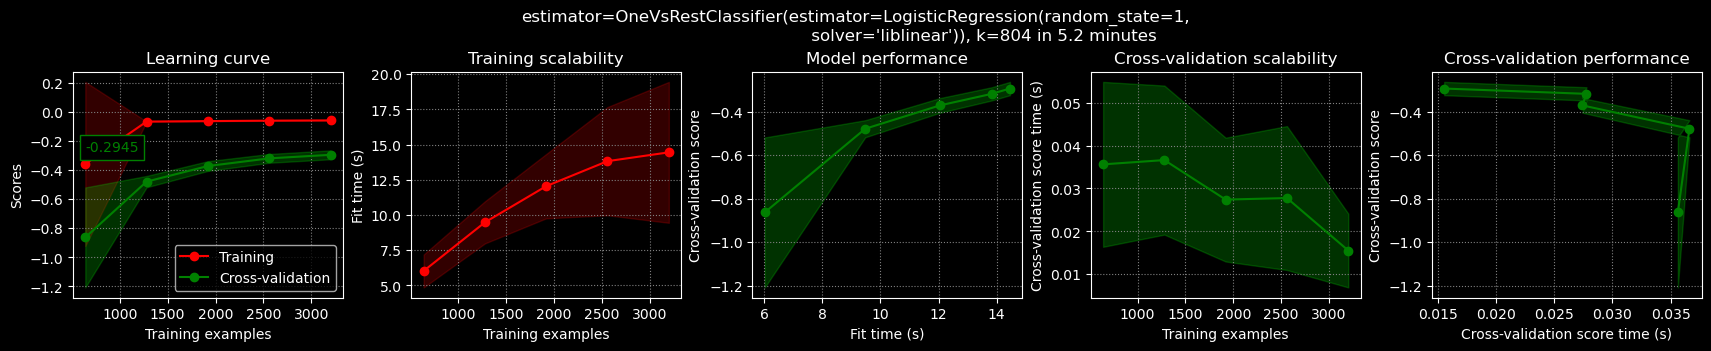

In [94]:
parameter_grid = build_parameter_grid(classifiers=classifiers,
                                      # k=k_space(start=np.sqrt(vocabulary_size), stop=vocabulary_size),
                                      # k=(np.linspace(.2, 1, 5) * vocabulary_size).astype(int),
                                      k=np.linspace(762, 804, 5).astype(int)
                                     )
multi_plot_learning_curves(baseline_pl, parameter_grid, X=sampling[FEATURES], y=dummy_labels, n_jobs=14, verbose=0)

## Regularization validation curve

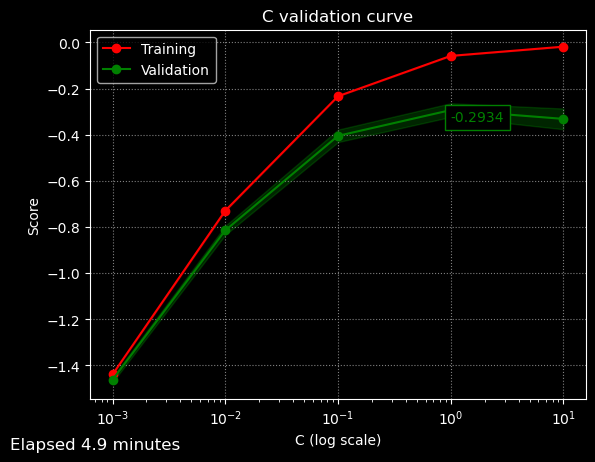

In [95]:
cloned_pl=clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = 772)
param_name='classifier__estimator__C'
param_range = np.logspace(np.log10(0.001), np.log10(10), 5)
param_label = 'C'
plot_validation_curve(cloned_pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=14
                     )
plt.show()

## Fit and predict

In [96]:
k = 772; C = 1
cloned_pl =  clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = k,
                     classifier__estimator__C = C,
                     classifier__n_jobs = 14,
                    )
modelname = f'{sampling.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(cloned_pl, sampling[FEATURES], dummy_labels, model_dir, modelname)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Fitting started on 2022-10-05T02:00
Done: 0.4 minutes
Saving cache 4002-k772-logistic-regression-C1 ... Done: 0.0 minutes
Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


liblinear, k 772, C 1, testing logloss 0.2934, driven data 0.5802

# 10% data sample

In [101]:
sampling = multilabel_sample_dataframe(df, y, size=0.1, min_count=28, seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
vocabulary_size = ngram_vocabulary_size(sampling[TEXT_FEATURES])
print('Sample size    :', sampling.shape[0])
print('Train sizes    :', (sampling.shape[0] * train_sizes * .8).astype('int'))
print('Test sizes     :', (sampling.shape[0] - (sampling.shape[0] * train_sizes * .8)).astype('int'))
print('Vocabulary size:', vocabulary_size)

Sample size    : 40027
Train sizes    : [ 6404 12808 19212 25617 32021]
Test sizes     : [33622 27218 20814 14409  8005]
Vocabulary size: 2624


## Learning curves

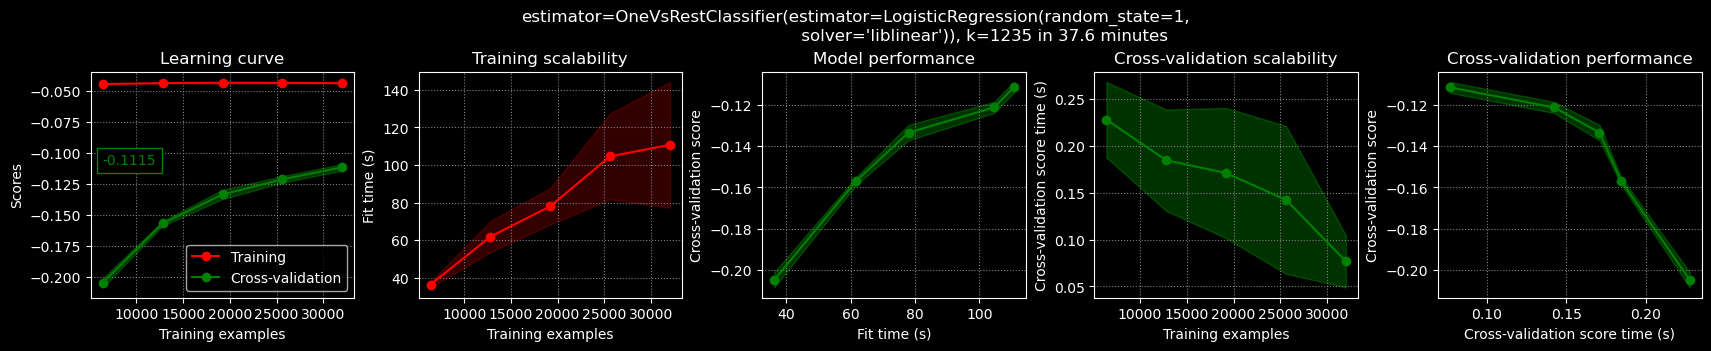

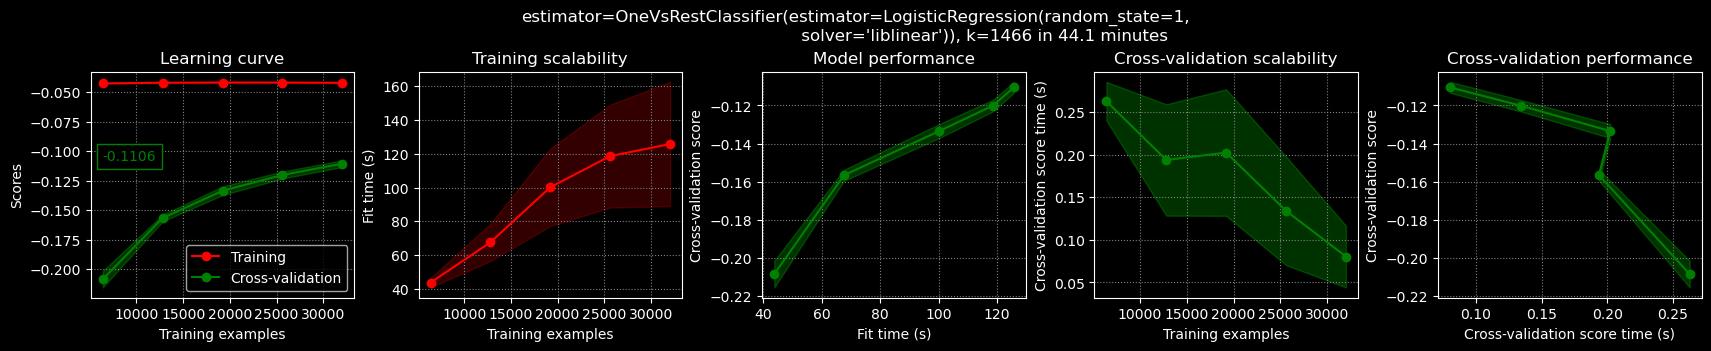

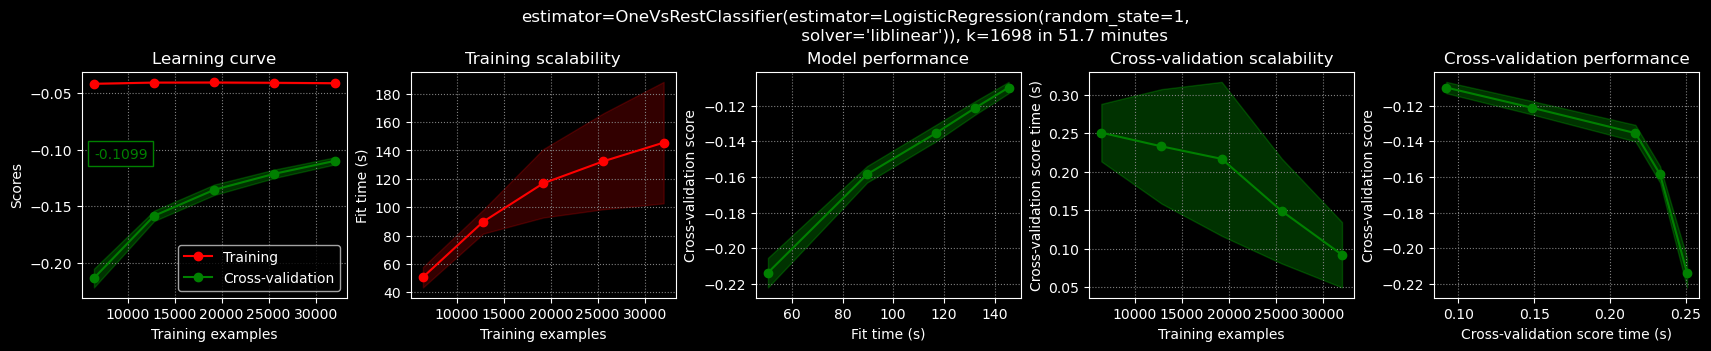

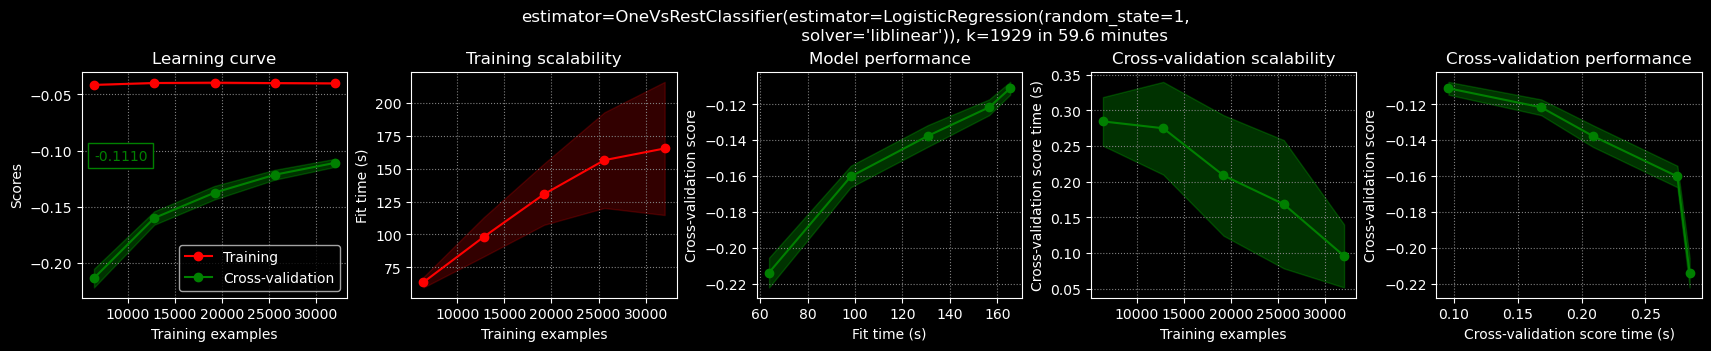

In [ ]:
parameter_grid = build_parameter_grid(classifiers=classifiers,
                                      # k=k_space(start=np.sqrt(vocabulary_size), stop=vocabulary_size),
                                      k=np.linspace(1466,  1929, 5).astype(int),
                                     )
multi_plot_learning_curves(baseline_pl, parameter_grid, X=sampling[FEATURES], y=dummy_labels, n_jobs=14, verbose=0)

## Regularization validation curve

In [ ]:
cloned_pl=clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = 2624)
param_name='classifier__estimator__C'
param_range = np.logspace(np.log10(0.001), np.log10(10), 5)
param_label = 'C'
plot_validation_curve(cloned_pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=14
                     )
plt.show()

## Fit and predict

In [93]:
k = 2624; C = 1
cloned_pl =  clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = k,
                     classifier__estimator__C = C,
                     classifier__n_jobs = 14,
                    )
modelname = f'{sampling.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(cloned_pl, sampling[FEATURES], dummy_labels, model_dir, modelname)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Fitting started on 2022-10-01T00:55
Done: 5.6 minutes
Saving cache 40027-k2624-logistic-regression-C1 ... Done: 0.0 minutes
Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


> liblinear, k 1441, C 1, test score 0.1136, driven data score 0.4831  
> liblinear, k 2624, C 1, test score 0.1123, driven data score 0.6343 !!!

# 20% data sample

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.2, min_count = 28, seed = 1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
vocabulary_size = ngram_vocabulary_size(sampling[TEXT_FEATURES])
print('Sample size    :', sampling.shape[0])
print('Train sizes    :', (sampling.shape[0] * train_sizes * .8).astype('int'))
print('Test sizes     :', (sampling.shape[0] - (sampling.shape[0] * train_sizes * .8)).astype('int'))
print('Vocabulary size:', vocabulary_size)

## Learning curves

In [ ]:
parameter_grid = build_parameter_grid(classifiers=classifiers,
                                      k=k_space(start=np.sqrt(vocabulary_size),
                                                stop=vocabulary_size))
multi_plot_learning_curves(baseline_pl, parameter_grid, X=sampling[FEATURES], y=dummy_labels, n_jobs=14, verbose=0)

## Regularization validation curve

In [ ]:
cloned_pl=clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = 1441)
param_name='classifier__estimator__C'
param_range = np.logspace(np.log10(0.001), np.log10(10), 5)
param_label = 'C'
plot_validation_curve(cloned_pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=14, xscale='linear'
                     )
plt.show()

## Fit and predict

In [ ]:
k = 1441; C = 1
cloned_pl =  clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = k,
                     classifier__estimator__C = C,
                     classifier__n_jobs = 14,
                    )
modelname = f'{sampling.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(cloned_pl, sampling[FEATURES], dummy_labels, model_dir, modelname)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

> liblinear, k 1441, C 1, testing logloss 0.0875 driven data 0.4818

> Having `ngram_range=(1,1)` and `k=1778`, the best parameter is `C=1.7782794100389228`, scoring `0.0837`, elapsed `872 minutes`

|sample|ngram| k| C|minutes|DrivenData's logloss|
|-----:|----:|-:|-:|------:|-------------------:|
|   0.2|(1,1)|1778|0.1778279410038923|17|0.4619|
|   0.2|(1,1)|1778|**0.31622776601683794**|19|**0.4609**|
|   0.2|(1,1)|1778|0.5623413251903491|21|0.4670|
|   0.2|(1,1)|1778|1|22|0.4800|
|   0.2|(1,1)|1778|1.7782794100389228|27|0.4995|

# 30% data sample

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.3, min_count = 28, seed = 1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
vocabulary_size = ngram_vocabulary_size(sampling[TEXT_FEATURES])
print('Sample size    :', sampling.shape[0])
print('Train sizes    :', (sampling.shape[0] * train_sizes * .8).astype('int'))
print('Test sizes     :', (sampling.shape[0] - (sampling.shape[0] * train_sizes * .8)).astype('int'))
print('Vocabulary size:', vocabulary_size)

## Learning curves

In [ ]:
parameter_grid = build_parameter_grid(classifiers=classifiers,
                                      k=k_space(start=np.sqrt(vocabulary_size),
                                                stop=vocabulary_size))
multi_plot_learning_curves(baseline_pl, parameter_grid, X=sampling[FEATURES], y=dummy_labels, n_jobs=14, verbose=0)

## Regularization validation curve

In [ ]:
cloned_pl=clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = 1441)
param_name='classifier__estimator__C'
param_range = np.logspace(np.log10(0.001), np.log10(10), 5)
param_label = 'C'
plot_validation_curve(cloned_pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=14, xscale='linear'
                     )
plt.show()

## Fit and predict

In [ ]:
k = 1441; C = 1
cloned_pl =  clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = k,
                     classifier__estimator__C = C,
                     classifier__n_jobs = 14,
                     #classifier__estimator__max_iter = 100
                    )
modelname = f'{sampling.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(cloned_pl, sampling[FEATURES], dummy_labels, model_dir, modelname)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

liblinear, C 1, k 1441, Testing log loss: 0.0768, Driven Data: 0.4899

>Having `ngram_range=(1,1)` and `k=1778`, the best parameter is `C=0.5623413251903491`, scoring `0.0757`, elapsed `704 minutes`.

# 50% data sample

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.5, min_count = 29, seed = 1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
vocabulary_size = ngram_vocabulary_size(sampling[TEXT_FEATURES])
print('Sample size    :', sampling.shape[0])
print('Train sizes    :', (sampling.shape[0] * train_sizes * .8).astype('int'))
print('Test sizes     :', (sampling.shape[0] - (sampling.shape[0] * train_sizes * .8)).astype('int'))
print('Vocabulary size:', vocabulary_size)

## Learning curves

In [ ]:
parameter_grid = build_parameter_grid(classifiers=classifiers,
                                      k=k_space(start=np.sqrt(vocabulary_size),
                                                stop=vocabulary_size))
multi_plot_learning_curves(baseline_pl, parameter_grid, X=sampling[FEATURES], y=dummy_labels, n_jobs=14, verbose=0)

In [ ]:
parameter_grid = \
build_parameter_grid(classifiers=classifiers,
                     k=k_space(start=1441,
                               stop=1441,
                               endpoint=True, # True,
                               num=1))
multi_plot_learning_curves(baseline_pl, parameter_grid, X=sampling[FEATURES], y=dummy_labels, n_jobs=14, verbose=0)

## Regularization validation curve

In [ ]:
cloned_pl=clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = 1441)
param_name='classifier__estimator__C'
param_range = np.logspace(np.log10(0.001), np.log10(10), 5)
param_label = 'C'
plot_validation_curve(cloned_pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=14, xscale='linear'
                     )
plt.show()

## Fit and predict

In [ ]:
k = 1441; C = 1
cloned_pl =  clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = k,
                     classifier__estimator__C = C,
                     classifier__n_jobs = 14,
                     #classifier__estimator__max_iter = 100
                    )
modelname = f'{sampling.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(cloned_pl, sampling[FEATURES], dummy_labels, model_dir, modelname)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

liblinear, k1441, C1 Test loglogss: 0.0677 Drivendata: 0.5014

# 60% data sample

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.6, min_count = 20, seed = 1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
vocabulary_size = ngram_vocabulary_size(sampling[TEXT_FEATURES])
print('Sample size    :', sampling.shape[0])
print('Train sizes    :', (sampling.shape[0] * train_sizes * .8).astype('int'))
print('Test sizes     :', (sampling.shape[0] - (sampling.shape[0] * train_sizes * .8)).astype('int'))
print('Vocabulary size:', vocabulary_size)

## Learning curves

In [ ]:
parameter_grid = build_parameter_grid(classifiers=classifiers,
                                      k=k_space(start=np.sqrt(vocabulary_size),
                                                stop=vocabulary_size))
multi_plot_learning_curves(baseline_pl, parameter_grid, X=sampling[FEATURES], y=dummy_labels, n_jobs=14, verbose=0)

## Regularization validation curve

In [ ]:
cloned_pl=clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = )
param_name='classifier__estimator__C'
param_range = np.logspace(np.log10(0.001), np.log10(10), 5)
param_label = 'C'
plot_validation_curve(cloned_pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=14, xscale='linear'
                     )
plt.show()

## Fit and predict

In [ ]:
k = ; C = 
cloned_pl =  clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = k,
                     classifier__estimator__C = C,
                     classifier__n_jobs = 14,
                     #classifier__estimator__max_iter = 100
                    )
modelname = f'{sampling.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(cloned_pl, sampling[FEATURES], dummy_labels, model_dir, modelname)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

# 80% data sample

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.8, min_count = 25, seed = 1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
vocabulary_size = ngram_vocabulary_size(sampling[TEXT_FEATURES])
print('Sample size    :', sampling.shape[0])
print('Train sizes    :', (sampling.shape[0] * train_sizes * .8).astype('int'))
print('Test sizes     :', (sampling.shape[0] - (sampling.shape[0] * train_sizes * .8)).astype('int'))
print('Vocabulary size:', vocabulary_size)

## Learning curves

In [ ]:
parameter_grid = build_parameter_grid(classifiers=classifiers,
                                      k=k_space(start=np.sqrt(vocabulary_size),
                                                stop=vocabulary_size))
multi_plot_learning_curves(baseline_pl, parameter_grid, X=sampling[FEATURES], y=dummy_labels, n_jobs=14, verbose=0)

## Regularization validation curve

In [ ]:
cloned_pl=clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = )
param_name='classifier__estimator__C'
param_range = np.logspace(np.log10(0.001), np.log10(10), 5)
param_label = 'C'
plot_validation_curve(cloned_pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=14, xscale='linear'
                     )
plt.show()

## Fit and predict

In [ ]:
k = ; C = 
cloned_pl =  clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = k,
                     classifier__estimator__C = C,
                     classifier__n_jobs = 14,
                     #classifier__estimator__max_iter = 100
                    )
modelname = f'{sampling.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(cloned_pl, sampling[FEATURES], dummy_labels, model_dir, modelname)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

# 100% data

In [ ]:
vocabulary_size = ngram_vocabulary_size(df[TEXT_FEATURES])
print('Sample size:', df.shape[0])
print('Train sizes:', (df.shape[0] * train_sizes * .8).astype('int'))
print('Test sizes :', (df.shape[0] - (df.shape[0] * train_sizes * .8)).astype('int'))
print('Vocabulary size:', vocabulary_size)

## Learning curves

In [ ]:
parameter_grid = build_parameter_grid(classifiers=classifiers,
                                      k=k_space(start=np.sqrt(vocabulary_size),
                                                stop=vocabulary_size))
multi_plot_learning_curves(baseline_pl, parameter_grid, X=sampling[FEATURES], y=dummy_labels, n_jobs=14, verbose=0)

## Regularization validation curve

In [ ]:
cloned_pl=clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = )
param_name='classifier__estimator__C'
param_range = np.logspace(np.log10(0.001), np.log10(10), 5)
param_label = 'C'
plot_validation_curve(cloned_pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=14, xscale='linear'
                     )
plt.show()

## Fit and predict

In [ ]:
k = ; C = 
cloned_pl =  clone(baseline_pl)
cloned_pl.set_params(union__text_features__reducer__k = k,
                     classifier__estimator__C = C,
                     classifier__n_jobs = 14,
                     #classifier__estimator__max_iter = 100
                    )
modelname = f'{sampling.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(cloned_pl, sampling[FEATURES], dummy_labels, model_dir, modelname)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

| sample | jobs | k    | interactions |logloss|  time | mem. peak |
| -----: | ---: | ---: | -------: |-------:| ---------: | --------: |
|    1.0 |    4 |  316 |  51681 | 0.0834 |  667.9 min |2.8-3.1 GiB|
|    1.0 |    4 |  562 | 161028 | 0.0686 |  998.1 min |2.8-3.1 GiB|
|    1.0 |    4 | 1000 | 505515 | 0.0623 | 1291.2 min |2.8-3.1 GiB|
|    1.0 |    4 | **1778** | 1590436 | **0.0586** | 1610.6 min |2.8-3.1 GiB|

Having `ngram_range=(1,1)` and `k=1778`, the best is `C=1.7782794100389228`, scoring `0.0581`, elapsed `2972 minutes`

|sample|ngram| k| C|minutes|DrivenData's logloss|
|-----:|----:|-:|-:|------:|-------------------:|
|   1.0|(1,1)|1778|0.01|80|0.4934|
|   1.0|(1,1)|1778|0.05623413251903491|80|0.4465|
|   1.0|(1,1)|1778|**0.1**|100|**0.4461**|
|   1.0|(1,1)|1778|0.1778279410038923|101|0.4530|
|   1.0|(1,1)|1778|0.31622776601683794|115|0.4675|
|   1.0|(1,1)|1778|0.5623413251903491|136|0.4889|
|   1.0|(1,1)|1778|1|150|0.5173|
|   1.0|(1,1)|1778|1.7782794100389228|177|0.5523|


# Parameter optimizations and predictions

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, log_loss

## 0.8% training, 0.2% testing

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.01, min_count = 7, seed = 1)
print('Sample size:', sampling.shape[0])
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES], dummy_labels,
                                                               size = 0.2, min_count = 1, seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '0.008-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

Fitting 5 folds for each of 15 candidates, totalling 75 fits, took ~120 minutes

In [ ]:
print('Time refitting best model on whole data  : {:.1f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k',
                                  'split0_test_multi_multi_log_loss':'split0_logloss',
                                  'split1_test_multi_multi_log_loss':'split1_logloss',
                                  'split2_test_multi_multi_log_loss':'split2_logloss',
                                  'split3_test_multi_multi_log_loss':'split3_logloss',
                                  'split4_test_multi_multi_log_loss':'split4_logloss',
                                  'mean_test_multi_multi_log_loss':'mean_test_logloss',
                                  'std_test_multi_multi_log_loss':'std_test_logloss',
                                  'rank_test_multi_multi_log_loss':'rank_test_logloss'
                                 })
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
#from sklearn.model_selection import cross_val_score
#pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')),
#              union__text_features__reducer__k = 562,
#              classifier__estimator__C = 1)
#cross_val_score(pl, X_train, y_train,
#                scoring = multi_multi_log_loss_scorer,
#                cv = 5,
#                n_jobs = -1,
#                verbose=11).mean()

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes
y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Testing data score         : {}".format(grid.score(X_test, y_test)))  # Takes some minutes

y_pred = grid.predict(X_test)  # Takes some minutes
report = pd.DataFrame(classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
# Testing score breakdown checking
y_pred = grid.predict_proba(X_test)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_test, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)

## 8% training, 2% testing

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.1, min_count = 2, seed = 1)
print('Sample size:', sampling.shape[0])
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES], dummy_labels,
                                                               size = 0.2, min_count = 0, seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '0.08-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

Fitting 5 folds for each of 15 candidates, totalling 75 fits, took 392 minutes

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
pl.set_params(union__text_features__reducer__k = 1000,
              classifier__estimator__C = 0.1)
cross_val_score(pl, X_train, y_train,
                scoring = multi_multi_log_loss_scorer,
                cv = 5,
                n_jobs = -1,
                verbose=11).mean()

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Testing data score         : {}".format(grid.score(X_test, y_test)))  # Takes some minutes

y_pred = grid.predict(X_test)  # Takes some minutes
report = pd.DataFrame(classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
# Testing score checking
y_pred = grid.predict_proba(X_test)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_test, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)

## 16% training, 4% testing **(TO RUN)**

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.2, min_count = 2, seed = 1)
print('Sample size:', sampling.shape[0])
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES], dummy_labels,
                                                               size = 0.2, min_count = 0, seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '0.016-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Testing data score         : {}".format(grid.score(X_test, y_test)))  # Takes some minutes

y_pred = grid.predict(X_test)  # Takes some minutes
report = pd.DataFrame(classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
# Testing score checking
y_pred = grid.predict_proba(X_test)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_test, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)

## 80% training, 20% testing **(TO RUN)**

In [ ]:
X_train,X_test,y_train,y_test = multilabel_train_test_split(df[FEATURES], y, size=0.2, min_count=0, seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '0.8-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Testing data score         : {}".format(grid.score(X_test, y_test)))  # Takes some minutes

y_pred = grid.predict(X_test)  # Takes some minutes
report = pd.DataFrame(classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
# Testing score checking
y_pred = grid.predict_proba(X_test)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_test, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)

## 100% training, 0% testing **(TO RUN)**

In [ ]:
df = df.sample(frac=1, random_state=1) # Ensure iid samples because CVGridSearch/KFold doesn't shuffle folding data
X_train = df[FEATURES]
y_train = pd.get_dummies(df[LABELS], prefix_sep='__')
del, X_test, y_test
print('Train size`:', y_train.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '1.0-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
# Training score checking
y_pred = grid.predict_proba(X_train)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_train, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)